In [1]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

In [2]:
# Constants
N = 10000   # Number of data points
K = 10      # Number of classes
D = 3072    # Number of dimensions

In [3]:
class Data():
    def __init__(self, filename=None):

        self.data = None
        self.hot = None
        self.labels = None

        if filename:
            self.setDataFromFile(filename)
            self.transform()

        # Precompute flipped indices
        indices = np.array(range(D))
        imageidx = indices.reshape(32, 32, 3, order="F")
        flipped_imageidx = np.flip(imageidx, axis=0)
        self.flipped_idx = flipped_imageidx.reshape(D, order="F")

    def loadData(self, filename):
        """ Copied from the dataset website """
        import pickle
        with open('../Datasets/cifar-10-batches-py/'+filename, 'rb') as fo:
            batch = pickle.load(fo, encoding='bytes')
        
        labels = np.array(batch[b"labels"])

        dict = {
         "labels": labels,
         "data": batch[b"data"].T.astype(float),
         "hot": self.onehotencoding(labels)
         }

        return dict

    def onehotencoding(self, labels):
        """
        One-hot encodes the given labels.
        
        Args:
            labels (np.array): The labels to be one-hot encoded.
            
        Returns:
            np.array: The one-hot encoded labels.
        """
        N = len(labels)
        hot = np.zeros((K, N))
        for i in range(N):
            hot[labels[i]][i] = 1
        return hot

    def setDataFromFile(self, fname):
        """
        Sets the data to the contents at the file filename.        
        """
        batch = self.loadData(fname)
        self.labels = batch["labels"]
        self.data = batch["data"]
        self.hot = batch["hot"]
    
    def concatData(self, fname):
        """
        Concatenates the data from the given filename to the existing data.
        
        Args:
            fname (str): The path to the file containing the data.
        """
        
        batch = self.loadData(fname)
        
        if self.labels is not None:
            self.labels = np.concatenate((self.labels, batch["labels"]))
        else:
            self.labels = batch["labels"]
        
        if self.data is not None:
            self.data = np.concatenate((self.data, batch["data"]), axis=1)
        else:
            self.data = batch["data"]

        self.hot = self.onehotencoding(self.labels)

    def transform(self):
        """
        Transforms the given dataset by normalizing the data.
        """
        meanX = np.mean(self.data, axis=0)
        stdX = np.std(self.data, axis=0)
        self.data = (self.data - meanX) / stdX
    
    def shuffle(self):
        """
        Shuffles the data.
        """
        permutation = np.random.permutation(self.data.shape[1])
        self.data = self.data[:, permutation]
        self.hot = self.hot[:, permutation]
        self.labels = self.labels[permutation]
    
    def miniBatch(self, batch, range):
        """
        Creates a mini-batch of the given batch.
        """
        self.data = batch.data[:, range[0]:range[1]]
        self.hot = batch.hot[:, range[0]:range[1]]
        self.labels = batch.labels[range[0]:range[1]]
    
    def flip(self, pflip):
        """
        Flips the data with a given probability.
        
        Args:
            pflip (float): The probability of flipping the data.
        """
        flip = np.random.rand(self.data.shape[1]) < pflip
        self.data[:,flip] = self.data[:,flip][self.flipped_idx]

In [4]:
class LinearLayer:
    def __init__(self):
        """
        Initializes the weights and biases of the layer.
        """
        self.W = np.random.normal(0,0.1,size=(K,D))
        self.b = np.random.normal(0,0.1,size=(K,1))
        self.P = None
        self.gradW = None
        self.gradB = None
    
    def softmax(self, x):
        """ Standard definition of the softmax function """
        return np.exp(x) / np.sum(np.exp(x), axis=0)

    def forward(self, batch):
        """
        Evaluate the classifier for a given input.

        Args:
            data (dict): A dictionary containing the data and one-hot encoded labels.
        """
        X = batch.data
        s = self.W @ X + self.b
        self.P = self.softmax(s)
    
    def lcross(self, batch):
        """
        Calculates the cross-entropy loss for a single example.

        Args:
            data (dict): A dictionary containing the data and one-hot encoded labels.

        Returns:
            float: Cross-entropy loss.
        """
        Y = batch.hot
        return - Y * np.log(self.P)
    
    def computeCost(self, batch, lmda):
        """
        Compute the cost function for linear regression with regularization.

        Args:
            data (dict): A dictionary containing the data and one-hot encoded labels.
            lmda (float): Regularization parameter.

        Returns:
        float: The computed cost.

        """
        X = batch.data

        reg_term = lmda * np.sum(self.W ** 2)

        loss_cross = self.lcross(batch)

        return 1 / X.shape[1] * np.sum(loss_cross) + reg_term, np.sum(loss_cross)
    
    def computeAcc(self, batch):
        """
        Compute the accuracy of the classifier.

        Args:
            data (dict): A dictionary containing the data and one-hot encoded labels.

        Returns:
            float: Accuracy of the classifier.

        """
        Y = batch.hot
        pred = np.argmax(self.P, axis=0)
        return np.mean(pred == np.argmax(Y, axis=0))
    
    def backward(self, batch, lmbd):
        """
        Compute the gradients of the cost function with respect to the parameters.

        Args:
            data (dict): A dictionary containing the data and one-hot encoded labels.
            lmbd (float): Regularization parameter.

        Returns:
            list: A list containing the gradients of the cost function with respect to the weight matrix W and the bias vector b.
        """
        X, Y = batch.data, batch.hot
    
        G = self.P - Y

        self.gradB = (1 / X.shape[1] * np.sum(G, axis = 1)).reshape((K,1))
        
        self.gradW = 1 / X.shape[1] * G @ X.T + 2 * lmbd * self.W

    def update(self, eta):
            """
            Update the parameters of the model.
            """
            self.W -= eta * self.gradW
            self.b -= eta * self.gradB

In [5]:
class Visualizer:
    def plotResults(self, title, costs, loss, accs, test_acc = None):
        """
        Plot the results of the training.
        """
        plt.figure(figsize=(16, 6))
        plt.suptitle(title)

        plt.subplot(1, 3, 1)
        plt.plot(costs["train"], label="Training")
        plt.plot(costs["val"], label="Validation")
        plt.xlabel("Epoch")
        plt.ylabel("Cost")
        plt.legend()

        plt.subplot(1, 3, 2)
        plt.plot(loss["train"], label="Training")
        plt.plot(loss["val"], label="Validation")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()

        plt.subplot(1, 3, 3)
        plt.plot(accs["train"], label="Training")
        plt.plot(accs["val"], label="Validation")
        if test_acc:
            plt.axhline(test_acc, color="red", label="Test Accuracy")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()

        plt.tight_layout()    
        plt.show()

    def genWeightImage(self, slice):
        """
        Generates an image from the given slice of the weight matrix.
        
        Args:
            slice (numpy.ndarray): The slice of the weight matrix.
            
        Returns:
            numpy.ndarray: The generated image.
        """
        
        img = slice.reshape(32, 32, 3, order="F")
        img = img - np.min(img)
        img = img / np.max(img)
        return img

    def genMatrixVisualization(self, title, W):
        plt.figure(figsize=(12, 6))

        for i in range(K):
            plt.subplot(2, 5, i+1)
            plt.imshow(self.genWeightImage(W[i, :]))
            plt.title(f"Slice {i}")

        plt.tight_layout()
        plt.suptitle(title)
        plt.show()

In [6]:
def miniBatchGD(train, lmbd=0.1, n_batch=100, eta=0.001, n_epochs=20, val=None, pflip=0):
        """
        Perform mini-batch gradient descent.

        Args:
            X (numpy.ndarray): Input data of shape (d, N).
            Y (numpy.ndarray): One-hot encoded true label of shape (K, N).
            W (numpy.ndarray): Weight matrix of shape (K, d).
            b (numpy.ndarray): Bias vector of shape (K, 1).
            lmbd (float, optional): Regularization parameter. Defaults to 0.1.
            n_batch (int, optional): Number of mini-batches. Defaults to 100.
            eta (float, optional): Learning rate. Defaults to 0.001.
            n_epochs (int, optional): Number of epochs. Defaults to 20.

        Returns:
            tuple: A tuple containing the weight matrix W and the bias vector b.
        """
        np.random.seed(20240405)
        
        costs = {"train" : [], "val" : []}
        loss = {"train" : [], "val" : []}
        accs = {"train" : [], "val" : []}

        model = LinearLayer()
        
        for epoch in tqdm(range(n_epochs)):
            # Shuffle data
            train.shuffle()

            n_mini_batches = int(N / n_batch)
            for j in range(n_mini_batches):
                # Assemble mini-batch
                batch = Data()
                j_start = j * n_batch
                j_end = (j + 1) * n_batch
                batch.miniBatch(train, [j_start, j_end])
                if pflip > 0:
                    batch.flip(pflip)

                model.forward(batch)
                model.backward(batch, lmbd)
                model.update(eta)

            c, l = model.computeCost(batch, lmbd)
            costs["train"].append(c)
            loss["train"].append(l)
            accs["train"].append(model.computeAcc(batch))
            if val:
                model.forward(val)
                c, l = model.computeCost(val, lmbd)
                costs["val"].append(c)
                loss["val"].append(l)
                accs["val"].append(model.computeAcc(val))
        return model, costs, loss, accs

# Basic setup, no changes

In [7]:
vis = Visualizer()

In [8]:
# Load in train and test data, train model, evaluate test accuracy.
train, val, test = Data("data_batch_1"), Data("data_batch_2"), Data("test_batch")
model, costs, loss, accs = miniBatchGD(train, lmbd=0.1, n_batch=100, eta=0.001, n_epochs=40, val=val)
model.forward(test)
test_acc = model.computeAcc(test)
print("Accuracy on test set:", test_acc)


  0%|          | 0/40 [00:00<?, ?it/s]

Accuracy on test set: 0.3163


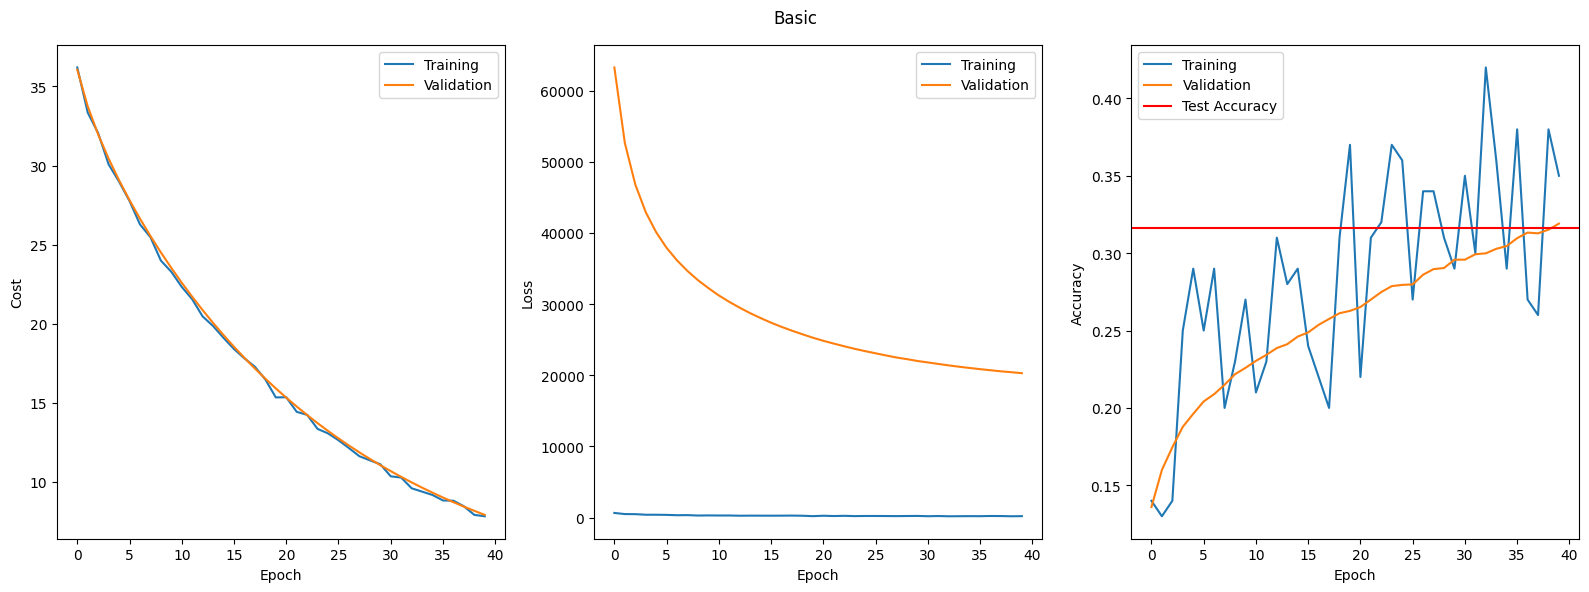

In [9]:
vis.plotResults("Basic", costs, loss, accs, test_acc)

# Expanded Training data

In [10]:
# Combine all training batches
train = Data()
for _ in range(5):
    train.concatData(f"data_batch_{_+1}")
train.transform()

# Partition test batch into validation and test sets
tmp = Data("test_batch")
range_val = [0, 1000]
range_test = [1000, 10000]

val = Data()
val.miniBatch(tmp, range_val)

test = Data()
test.miniBatch(tmp, range_test)

del tmp

In [11]:
np.random.seed(20240405)
modelexp, costs, loss, accs = miniBatchGD(train, lmbd=0.1, n_batch=100, eta=0.001, n_epochs=40, val=val)

  0%|          | 0/40 [00:00<?, ?it/s]

In [12]:
modelexp.forward(test)
test_acc = modelexp.computeAcc(test)
print("Accuracy on test set:", test_acc)

Accuracy on test set: 0.3198888888888889


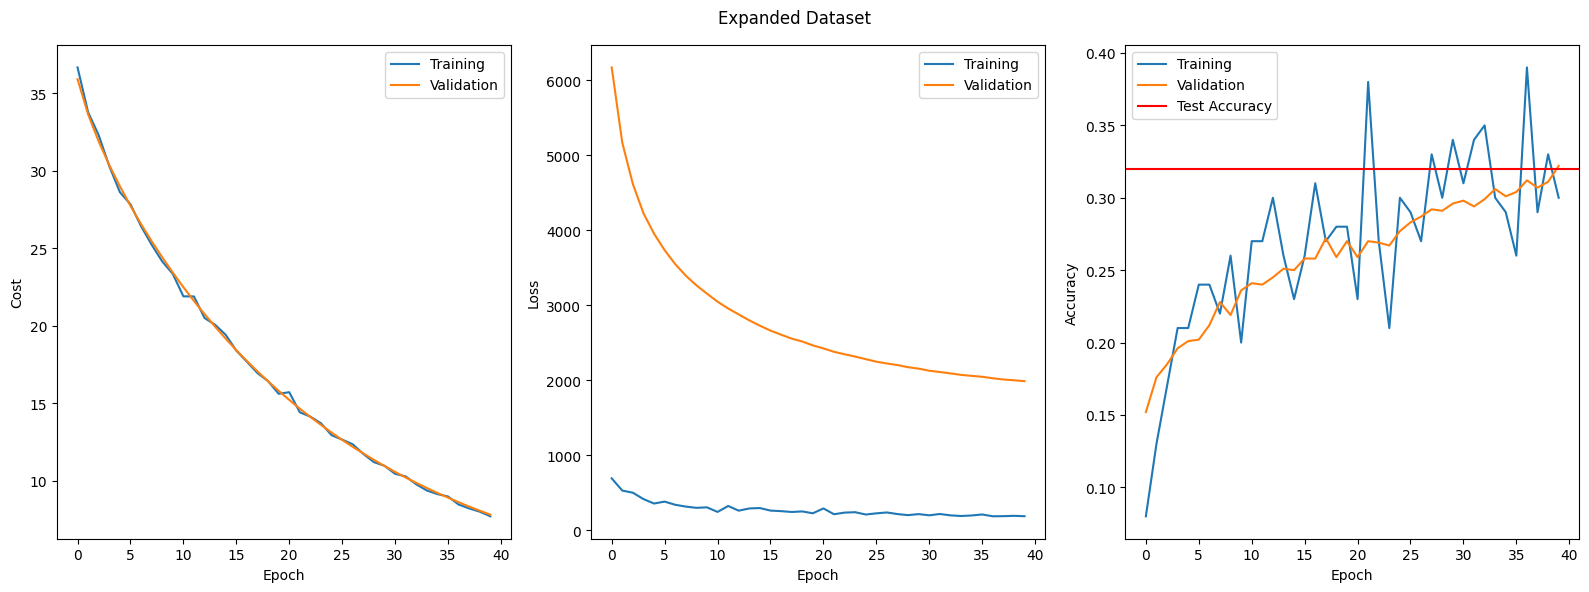

In [13]:
vis.plotResults("Expanded Dataset", costs, loss, accs, test_acc)

# Data augmentation

In [21]:
# Load in train and test data, train model, evaluate test accuracy.
train, val, test = Data("data_batch_1"), Data("data_batch_2"), Data("test_batch")

model, costs, loss, accs = miniBatchGD(train, lmbd=0.1, n_batch=100, eta=0.001, n_epochs=40, val=val, pflip=0.5)
model.forward(test)
test_acc = model.computeAcc(test)
print("Accuracy on test set:", test_acc)

  0%|          | 0/40 [00:00<?, ?it/s]

Accuracy on test set: 0.3191


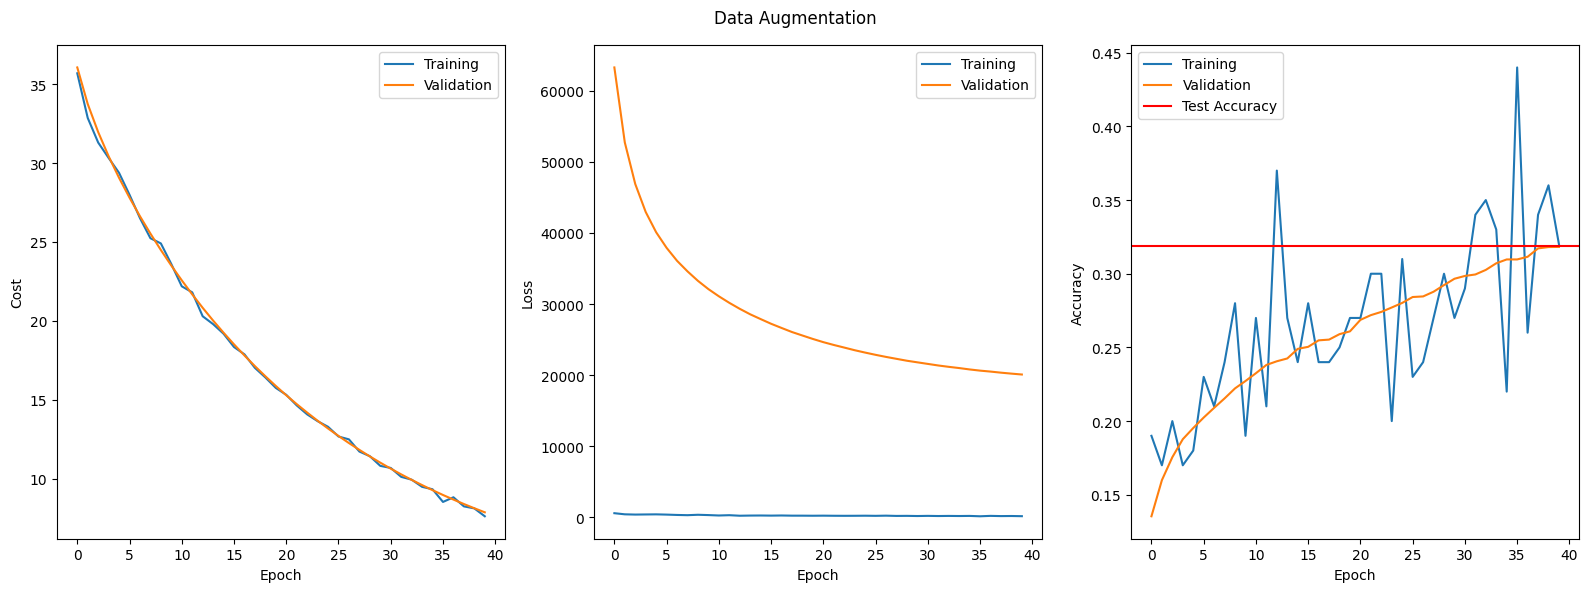

In [20]:
vis.plotResults("Data Augmentation", costs, loss, accs, test_acc)

# Hyperparameter tuning

In [39]:
import itertools

In [40]:
lmbd_list = [0, 0.01, 0.1, 0.5, 1, 1.5, 3, 5]
eta_list = [0.0001, 0.001, 0.01, 0.1, 0.5]
n_batch_list = [10, 50, 100, 200, 500]

paramSets = itertools.product(lmbd_list, eta_list, n_batch_list)

In [42]:
best = {"lmbd": None, "eta": None, "n_batch": None, "acc": 0}

for lmbd, eta, n_batch in paramSets:
    # Load in train and test data, train model, evaluate test accuracy.
    train, val, test = Data("data_batch_1"), Data("data_batch_2"), Data("test_batch")
    model, costs, loss, accs = miniBatchGD(train, lmbd=lmbd, n_batch=n_batch, eta=eta, n_epochs=40, val=val)

    print(f"Accuracy on test set for lambda = {lmbd}, eta = {eta}, n_batch = {n_batch}:", accs["val"][-1])
    
    if accs["val"][-1] > best["acc"]:
        best["lmbd"] = lmbd
        best["eta"] = eta
        best["n_batch"] = n_batch
        best["acc"] = accs["val"][-1]

  0%|          | 0/40 [00:00<?, ?it/s]

Accuracy on test set for lambda = 0, eta = 0.0001, n_batch = 10: 0.2668


  0%|          | 0/40 [00:00<?, ?it/s]

KeyboardInterrupt: 